# Downloading streamflow and weather data using APIs
---

**Objectives:**

By the end of this exercise, you should be able to:
* to get streamflow and weather data from two APIs (Application Programming Interface), USGS web platform and NOAA's bulk data interface 
* to automate both process using python packages (i.e., hydrofunctions and meteostat)
* to plot streamflow and precipitation time series
* to correlate streamflow and precipitation

---

In this exercise, we will use Lake Raleigh as our study case. We will leverage the [hydrofunctions](https://hydrofunctions.readthedocs.io/en/latest/authors.html) python package to access the streamflow time series from USGS gauging stations—using a python or R package is the most convenient way to retrieve streamflow information from multiple USGS stations. In addition, we will apply [meteostats](https://dev.meteostat.net/python/) to access weather data from the NOAA meteorological stations.

#### What is an API and how does it work?

Application Programming Interface can be thought of as a service between two applications. For example, the application sending a request (i.e., client or user), and the application sending the response to the request (i.e., the USGS web platform or NOAA's bulk data interface).

Check out this video [below]("https://youtu.be/s7wmiS2mSXY").

<a href="https://youtu.be/s7wmiS2mSXY">
<p align="center">
    <img src='imgs/api.png' width='600' /> 
</p>

##### Installing the necessary packages

Open your anaconda prompt, activate your environment and run:

$ pip install hydrofunctions  

$ pip install meteostats 

#### Downloading streamflow time series

In [7]:
import hydrofunctions as hf
import matplotlib.pyplot as plt
%matplotlib inline

We will retrieve streamflow time series between **01-01-2020** and **01-01-2022** for the Lake Raleigh's closest USGS station. To do so, we first need to get the site number ("**site_no**") [here](https://dashboard.waterdata.usgs.gov/app/nwd/?region=lower48&aoi=default). Basically, zoom in to Lake Raleigh's extent, and click or hover your mouse on the closest station. Then, get the 10 digits USGS station number. 

The second step is to define the type of "**service**" that we will request from the API. It can either be "iv" (instantaneous values) or "dv" (default, daily mean values). In our case, we want the daily mean. For last, we will define the start_date ("**st_date**") and end_date ("**end_date**").

For more information, check the package [documentation](https://hydrofunctions.readthedocs.io/en/latest/index.html). 

In [4]:
# general objects
site_no = '' # add the site_no here
service = 'dv'
st_date, end_date = '2021-01-01', '2022-01-01'

# flow in ft3/s
daily_mean = hf.NWIS(site=site_no, service=service, start_date=st_date, end_date=end_date)
daily_mean_values = daily_mean.df('q').shift(4, freq='H')

daily_mean_values.head()

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=0208734210&startDT=2021-01-01&endDT=2022-01-01


,USGS:0208734210:00060:00003
datetimeUTC,
2021-01-01 04:00:00+00:00,43.9
2021-01-02 04:00:00+00:00,49.5
2021-01-03 04:00:00+00:00,175.0
2021-01-04 04:00:00+00:00,35.1
2021-01-05 04:00:00+00:00,17.5


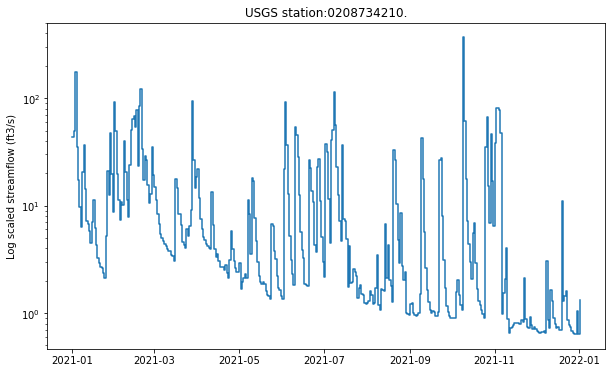

In [10]:
# check streamflow time series
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(daily_mean_values.loc[st_date:end_date].index.values, daily_mean_values.loc[st_date:end_date].values, where='post')
plt.yscale('log') # plotting with a log scale
plt.ylabel('Log scaled streamflow (ft3/s)')
plt.title(f'USGS station:{site_no}.')
plt.show()

#### Downloading weather variables time series

In [11]:
from datetime import datetime
from meteostat import Point, Daily

Using the package [meteostats](https://dev.meteostat.net/python/) we are able to access open weather and climate information (see data sources [here](https://dev.meteostat.net/sources.html)), for instance, from [NOAA's](https://www.weather.gov/) API. The package allows us to have access to raw observations of individual weather stations, or use a **point data** to query data by geographic location. For a complete list of climate variables and their units, please see [here](https://dev.meteostat.net/formats.html#meteorological-parameters).

Point data is available for almost all geographic locations. It only returns data if there is at least one nearby weather station. For further details, please see [here](https://dev.meteostat.net/python/point.html#example). 

To get data for a specific point, you first need the point's Latitude and Longitude, which can be retrieved using this [website](https://www.latlong.net/).
Use the Latitude and Longitude values below.

In [39]:
# the package uses datetime format dates!
st_date, end_date = datetime(2021,1,1), datetime(2022,1,1)

# Create Point for Lake Raleigh
# add Lake Raleigh's lat and long here! It must be a number, for instance, 37.76 and -18.68
lat, long =  , # <-- add lat and long here.
lake_raleigh = Point(lat,long)

# Get daily data between Jan 2021 and Jan 2022
weather_data = Daily(lake_raleigh, st_date, end_date)
weather_data = weather_data.fetch()

weather_data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2021-01-01,8.1,5.0,12.8,16.5,0.0,56.0,12.6,NaN,1024.4,NaN
2021-01-02,8.1,5.6,13.9,15.2,0.0,313.0,5.0,NaN,1016.4,NaN
2021-01-03,10.7,6.7,12.8,23.6,0.0,4.0,5.0,NaN,1013.1,NaN
2021-01-04,6.4,1.1,9.4,0.0,0.0,352.0,1.8,NaN,1016.4,NaN
2021-01-05,2.8,-1.6,8.9,0.0,0.0,341.0,2.2,NaN,1014.1,NaN


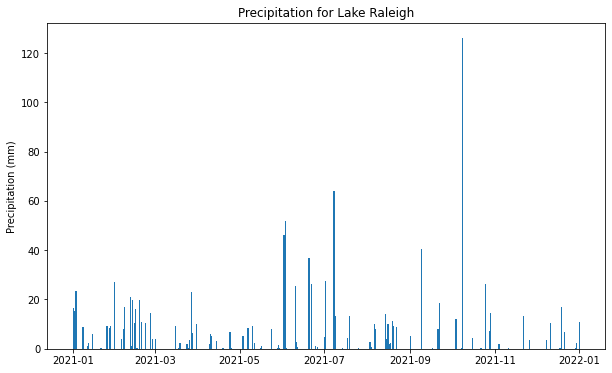

In [40]:
# plot precipitation
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(weather_data.loc[st_date:end_date].index.values, weather_data.loc[st_date:end_date]['prcp'].values)
plt.ylabel('Precipitation (mm)')
plt.title(f'Precipitation for Lake Raleigh')
plt.show()

#### Correlation between streamflow and precipitation

We can calculate Pearson's correlation using the covariance of streamflow and precipitation, divided by the product of their standard deviation.

Pearson's correlation coefficient = covariance(streamflow, precipitation) / (stdv(streamflow) * stdv(precipitation))

Or we can simply use numpy's function **np.corrcoef()**, for further details check the function's [documentation](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html).

In [46]:
import numpy as np

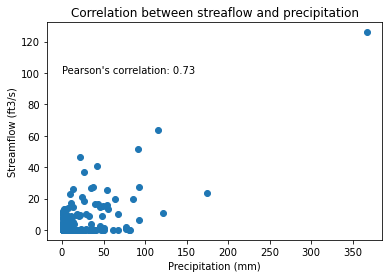

In [59]:
streamflow = daily_mean_values.iloc[:,0].values
precip = weather_data['prcp'].values
p_corr = np.corrcoef(streamflow, precip)

plt.scatter(streamflow, precip)
plt.text(0,100,f"Pearson's correlation: {np.round(p_corr[1, 0],2)}")
plt.ylabel('Streamflow (ft3/s)')
plt.xlabel('Precipitation (mm)')
plt.title(f'Correlation between streaflow and precipitation')
plt.show()